# Synthetic Image Generator for YOLOv8

This notebook generates synthetic images for the training, validation and testing. The output of this notebook is required by the **Training+Export.ipynb** notebook.

Authors(s): *Diptabrata Paul, Martin Fränzl*

In [83]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.patches as patches
from matplotlib import colormaps as cmaps
import os
from tqdm import tqdm
import yaml
from importlib import reload  # Python 3.4+

import image_generator as ig 
pi = np.pi

## Display single image for parameter adjustments

In [76]:
reload(ig)
n_list = [0, 20]                            # Number of points in each class

label_list = ['Spot', 'Ripple']               # Class of points
color_list = ['cyan', 'yellow']             # Color List for each class

# parameters for each class: [[[intensity], [radius], [width]]]
spot_params = [[[0], [4]]]
ring_params = [[[10,20], [100,100], [-55,55]]]

parameter_list = [spot_params, ring_params]

image_size = 512            # Dimension 
distance = 20               # Min distance between points
offset = 10                 # Boundary padding

objects = ig.getRandom(n_list, image_size, distance, offset, label_list, parameter_list)


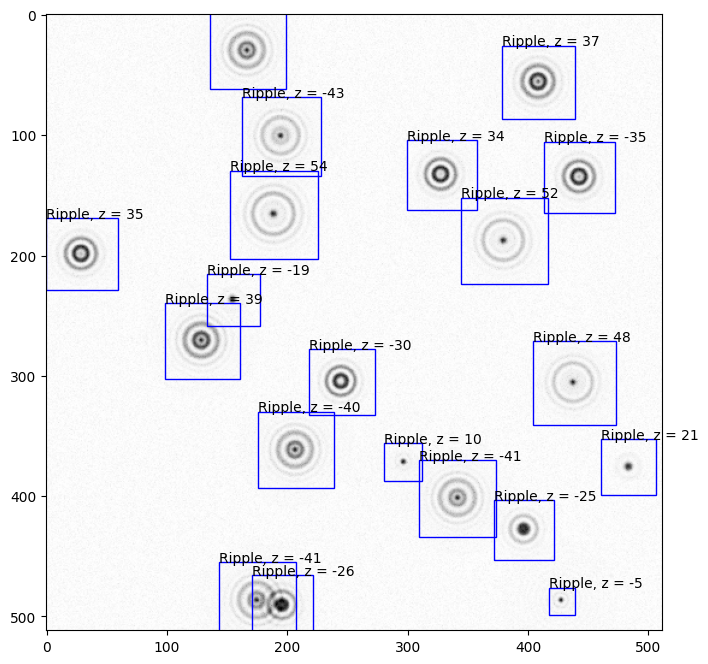

In [86]:
snr_range = [60,60]
i_range = [10, 20]
reload(ig)

bboxes, labels, image = ig.generateImage(objects, image_size, snr_range, i_range)

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap=cmaps["Grays"])
ax = fig.gca()
for bbox, label in zip(bboxes, labels):
    x, y = bbox[0]
    x1, y1 = bbox[1]
    ax.add_patch(patches.Rectangle((x,y), x1-x, y1-y, linewidth=1, edgecolor="blue", facecolor='none'))
    ax.annotate(label, (x,y))

## Generate images for training, validation and testing

In [4]:
subdir = 'Dataset/'
nimages = [50, 10, 10]
folders = ['train', 'val', 'test']

if not os.path.exists(subdir):
    os.mkdir(subdir)
for i, prefix in enumerate(folders):
    i_dir = subdir + '/' + prefix + '/'
    if not os.path.exists(i_dir):
        os.mkdir(i_dir)
        image_dir = i_dir + '/' + 'images' + '/'
        label_dir = i_dir + '/' + 'labels'+ '/'
        os.mkdir(image_dir)
        os.mkdir(label_dir)
    else:
        image_dir = i_dir + '/' + 'images' + '/'
        label_dir = i_dir + '/' + 'labels'+ '/'
        
    for i in tqdm(range(nimages[i])):
        objects = ig.getRandom(n_list, image_size, distance, offset, label_list, parameter_list)
        bboxes, labels, image = ig.generateImage(objects, image_size, snr_range, i_range) 
        fname = image_dir + 'image_{:04d}.jpg'.format(i,2)
        plt.imsave(fname, image, cmap='gray')
        annotations =[]
        for bbox, label in zip(bboxes, labels):
            x_center = ((bbox[0][0] + bbox[1][0]) / 2) / image_size
            y_center = ((bbox[0][1] + bbox[1][1]) / 2) / image_size
            width = (bbox[1][0] - bbox[0][0]) / image_size
            height = (bbox[1][1] - bbox[0][1]) / image_size
            class_id = np.where(np.array(label_list) == label)[0][0]

            annotation = f"{class_id} {x_center} {y_center} {width} {height}"
            annotations.append(annotation)
        labelname = label_dir + 'image_{:04d}.txt'.format(i,2)    
        np.savetxt(labelname, annotations, fmt='%s')
        # print(annotations)
        
# ig.exportConfig(subdir + 'info.txt', nimages, label_list, parameters_list, n_list, snr_range, i_range, distance, offset)

100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


### Generate .yaml file:

In [5]:
file_path = 'dataset.yaml'

dict = {}
for i, prefix in enumerate(folders):
    i_dir =  os.getcwd() + '/' + subdir + prefix
    dict[prefix]=str(i_dir)

dict['nc'] = len(label_list)
dict['names'] = label_list

with open(file_path, 'w') as file:
    yaml.dump(dict, file, default_flow_style=True)